In [1]:
import pandas as pd
import zstandard as zstd
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
CALENDAR_DATA_V2_PATH = "../data/raw/v2/calendar.csv.zst"
LISTINGS_DATA_V2_PATH = '../data/raw/v2/listings.csv.zst'
REVIEWS_DATA_V2_PATH = '../data/raw/v2/reviews.csv.zst'
SESSIONS_DATA_V2_PATH = '../data/raw/v2/sessions.csv.zst'
USERS_DATA_V2_PATH = '../data/raw/v2/users.csv.zst'



In [3]:
def read_large_csv_zst(file_path, chunksize=100000, **kwargs):
    dctx = zstd.ZstdDecompressor()
    with open(file_path, 'rb') as fh:
        with dctx.stream_reader(fh) as reader:
            text_stream = io.TextIOWrapper(reader, encoding='utf-8')
            chunk_iter = pd.read_csv(text_stream, chunksize=chunksize, **kwargs)
            for chunk in chunk_iter:
                yield chunk

def create_dataframe_from_csv_zst(filepath: str) -> pd.DataFrame:
    dctx = zstd.ZstdDecompressor()
    with open(filepath, 'rb') as compressed:
        with dctx.stream_reader(compressed) as reader:
            decompressed = io.TextIOWrapper(reader, encoding='utf-8')
            df = pd.read_csv(
                decompressed,
                low_memory=True
            )
    return df

In [5]:
callendar_df = create_dataframe_from_csv_zst(CALENDAR_DATA_V2_PATH)
listings_df = create_dataframe_from_csv_zst(LISTINGS_DATA_V2_PATH)
reviews_df = create_dataframe_from_csv_zst(REVIEWS_DATA_V2_PATH)
users_df = create_dataframe_from_csv_zst(USERS_DATA_V2_PATH)

/tmp/ipykernel_373/762385955.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_373/762385955.py:15: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


### Missing Values

In [4]:
# checking missing values in the dataframes
def check_dataframe_missing_values(df: pd.DataFrame) -> None:
    total_values = len(df)

    df_columns = df.columns

    for col in df_columns:
        missing_values = df[col].isnull().sum()
        missing_percentage = (missing_values / total_values) * 100
        print(f"Column: {col}, Missing Values: {missing_values}, Missing Percentage: {missing_percentage:.2f}%")


def missing_values_visualization(df: pd.DataFrame, title: str, figsize: tuple = (12,6)) -> None:
    plt.figure(figsize=(12, 6))

    counts = []
    for col in df.columns:
        counts.append({'column': col, 'status': 'Existing', 'count': df[col].notnull().sum()})
        counts.append({'column': col, 'status': 'Missing', 'count': df[col].isna().sum()})
    counts_df = pd.DataFrame(counts)

    plt.figure(figsize=figsize)
    sns.barplot(data=counts_df, x='column', y='count', hue='status', edgecolor='black')
    plt.title(title)
    plt.xticks(rotation=90)

    plt.show()


Column: listing_id, Missing Values: 0, Missing Percentage: 0.00%
Column: date, Missing Values: 0, Missing Percentage: 0.00%
Column: available, Missing Values: 0, Missing Percentage: 0.00%
Column: price, Missing Values: 0, Missing Percentage: 0.00%
Column: adjusted_price, Missing Values: 14580728, Missing Percentage: 100.00%
Column: minimum_nights, Missing Values: 6899, Missing Percentage: 0.05%
Column: maximum_nights, Missing Values: 6899, Missing Percentage: 0.05%


<Figure size 1200x600 with 0 Axes>

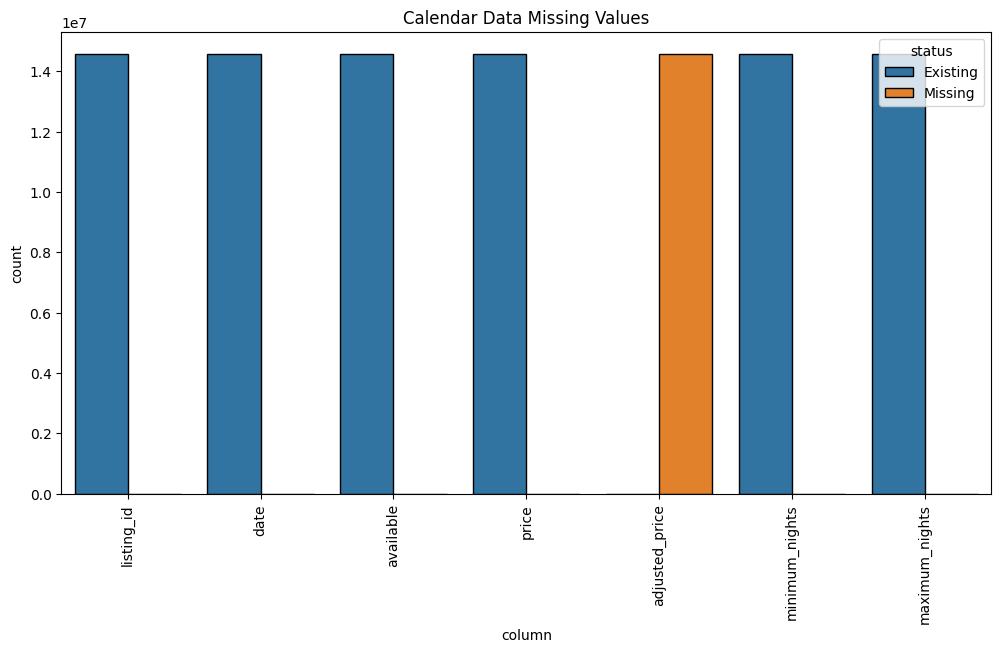

In [6]:
check_dataframe_missing_values(callendar_df)
missing_values_visualization(callendar_df, "Calendar Data Missing Values")

Column: id, Missing Values: 0, Missing Percentage: 0.00%
Column: listing_url, Missing Values: 0, Missing Percentage: 0.00%
Column: scrape_id, Missing Values: 0, Missing Percentage: 0.00%
Column: last_scraped, Missing Values: 0, Missing Percentage: 0.00%
Column: source, Missing Values: 0, Missing Percentage: 0.00%
Column: name, Missing Values: 0, Missing Percentage: 0.00%
Column: description, Missing Values: 1207, Missing Percentage: 3.02%
Column: neighborhood_overview, Missing Values: 21014, Missing Percentage: 52.63%
Column: picture_url, Missing Values: 1, Missing Percentage: 0.00%
Column: host_id, Missing Values: 0, Missing Percentage: 0.00%
Column: host_url, Missing Values: 0, Missing Percentage: 0.00%
Column: host_name, Missing Values: 19, Missing Percentage: 0.05%
Column: host_since, Missing Values: 19, Missing Percentage: 0.05%
Column: host_location, Missing Values: 12112, Missing Percentage: 30.33%
Column: host_about, Missing Values: 19822, Missing Percentage: 49.64%
Column: hos

<Figure size 1200x600 with 0 Axes>

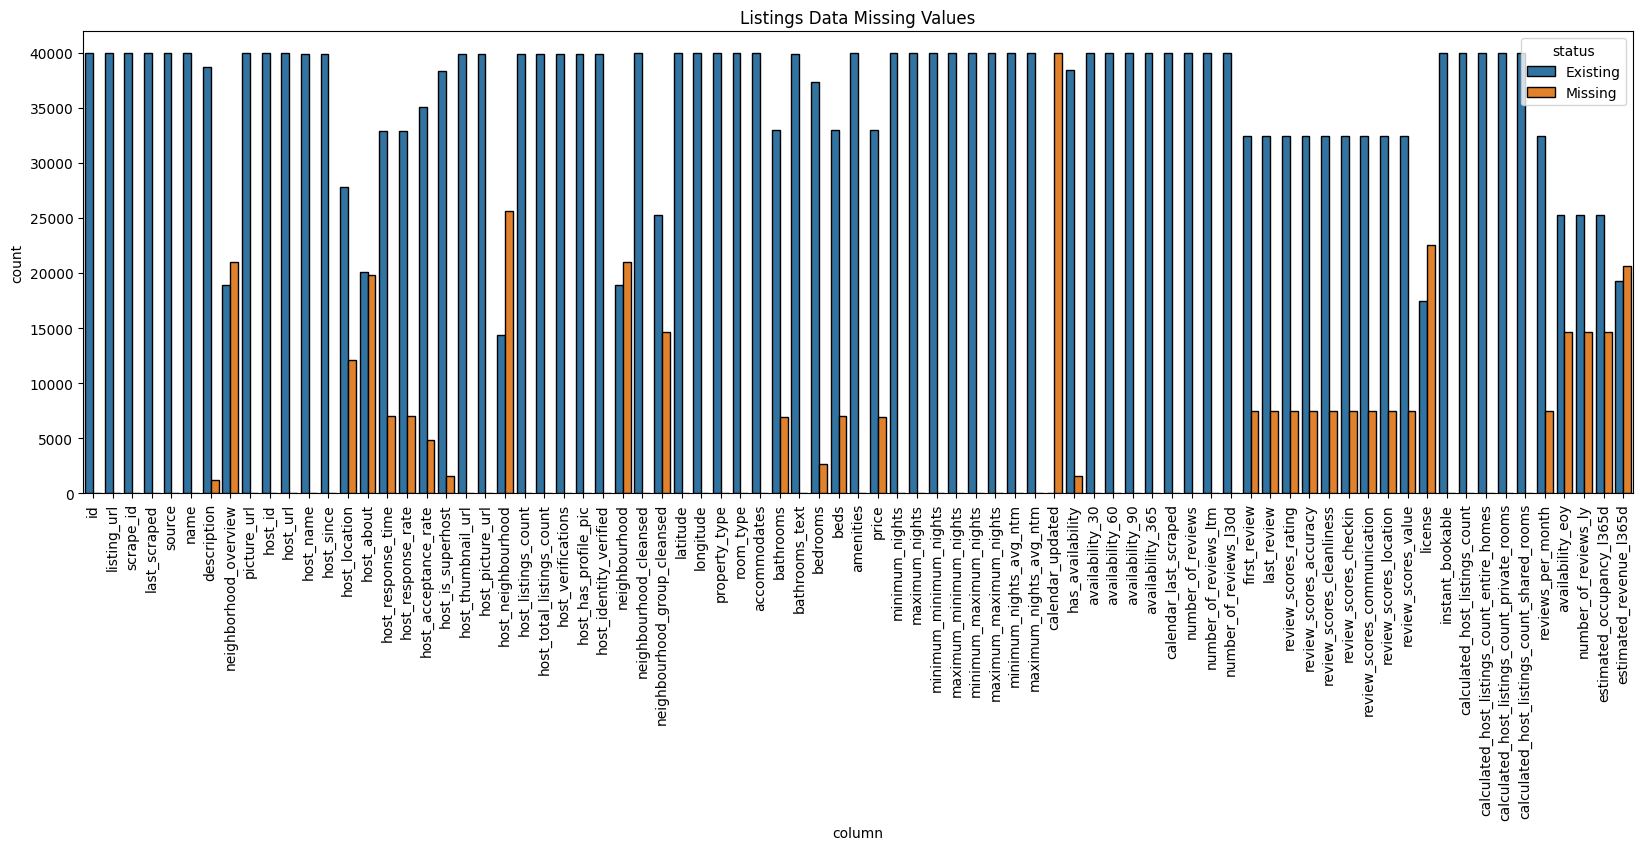

In [8]:
check_dataframe_missing_values(listings_df)
missing_values_visualization(listings_df, "Listings Data Missing Values", figsize=(20, 6))


Column: listing_id, Missing Values: 0, Missing Percentage: 0.00%
Column: id, Missing Values: 0, Missing Percentage: 0.00%
Column: date, Missing Values: 0, Missing Percentage: 0.00%
Column: reviewer_id, Missing Values: 0, Missing Percentage: 0.00%
Column: reviewer_name, Missing Values: 3, Missing Percentage: 0.00%
Column: comments, Missing Values: 156, Missing Percentage: 0.01%


<Figure size 1200x600 with 0 Axes>

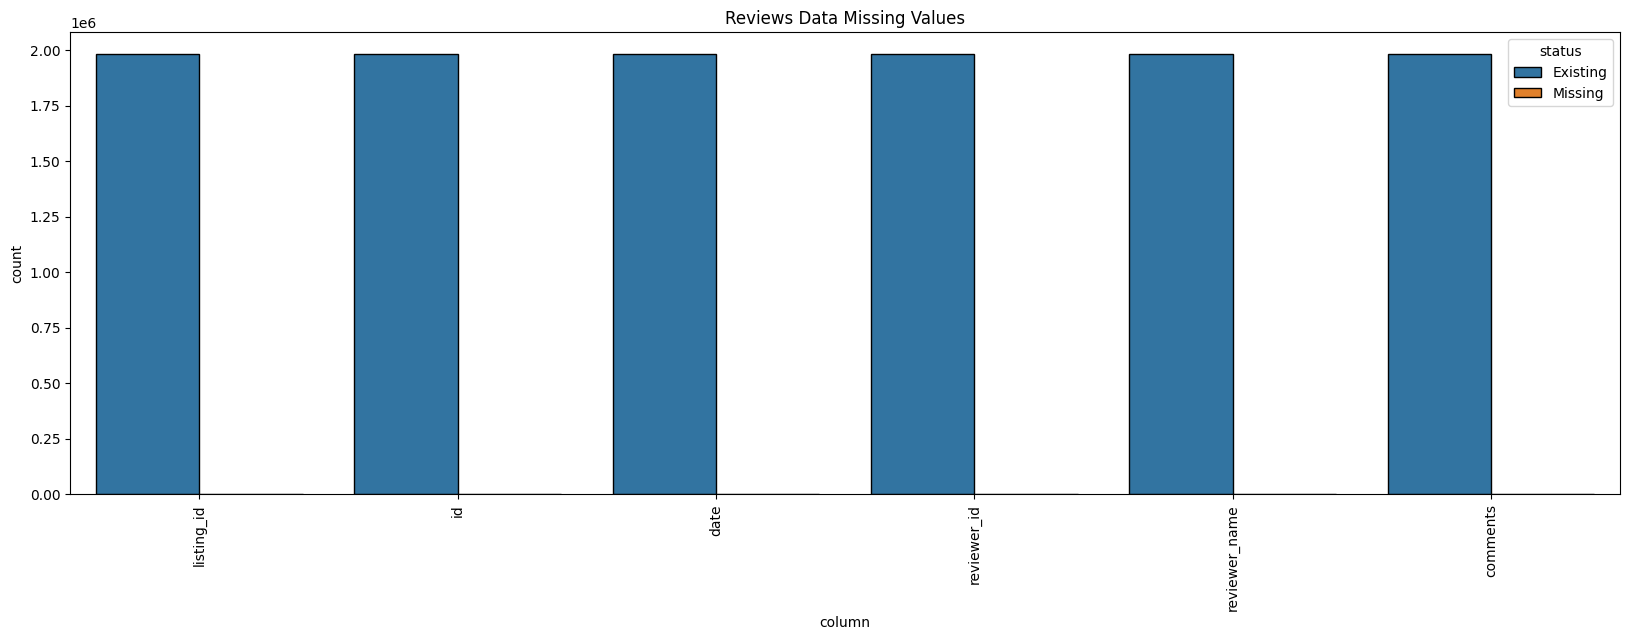

In [9]:
check_dataframe_missing_values(reviews_df)
missing_values_visualization(reviews_df, "Reviews Data Missing Values", figsize=(20, 6))

Column: id, Missing Values: 0, Missing Percentage: 0.00%
Column: name, Missing Values: 0, Missing Percentage: 0.00%
Column: surname, Missing Values: 0, Missing Percentage: 0.00%
Column: city, Missing Values: 0, Missing Percentage: 0.00%
Column: street, Missing Values: 0, Missing Percentage: 0.00%
Column: street_number, Missing Values: 0, Missing Percentage: 0.00%
Column: postal_code, Missing Values: 0, Missing Percentage: 0.00%


<Figure size 1200x600 with 0 Axes>

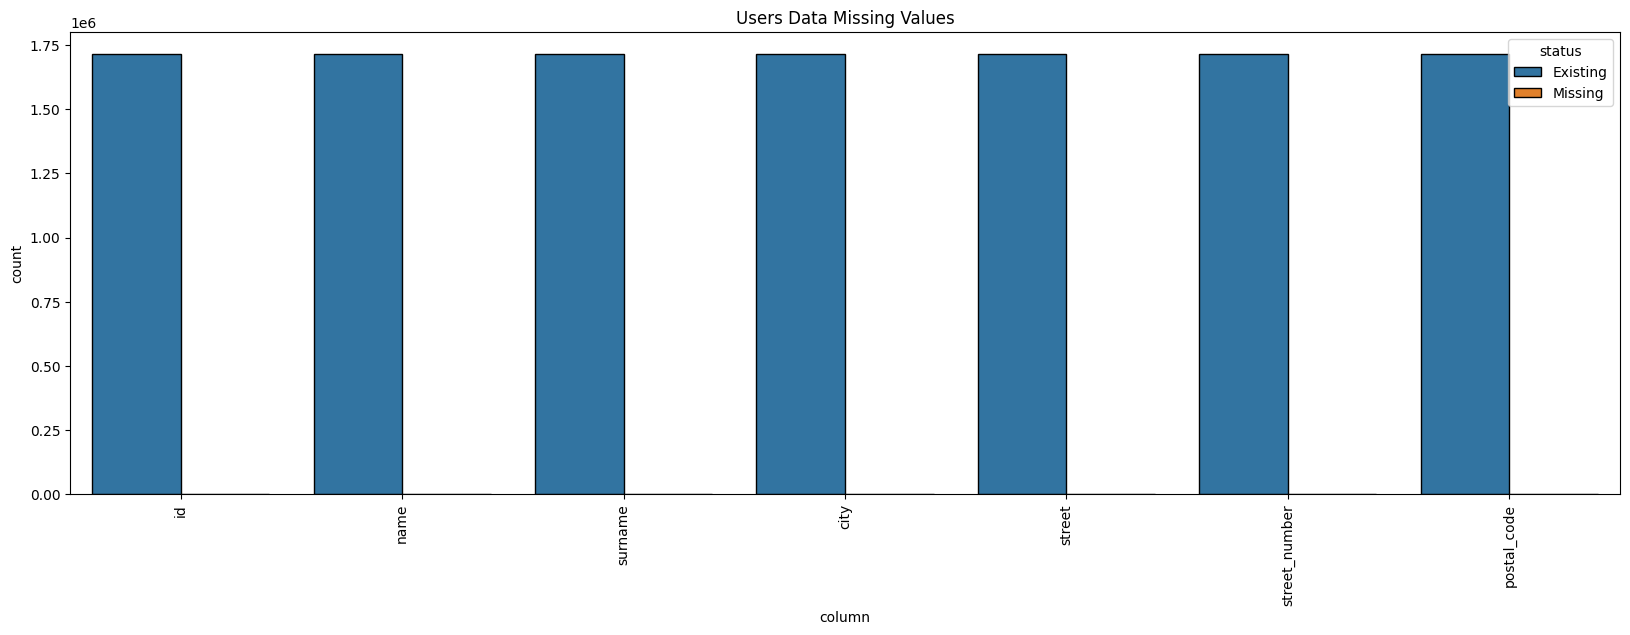

In [10]:
check_dataframe_missing_values(users_df)
missing_values_visualization(users_df, "Users Data Missing Values", figsize=(20, 6))

### Missing values in sessions

In [23]:
# getting columns names
for chunk in read_large_csv_zst(SESSIONS_DATA_V2_PATH, nrows=1):
    columns = chunk.columns
    break


In [ ]:
columns_list = list(columns)

In [ ]:
def calculate_missing_values_in_sessions_data(file_path: str) -> dict:
    # initialize dictionary to store aggregated counts for each column
    missing_stats = {col: {'total_values': 0, 'missing_values': 0} for col in columns_list}

    # iterate over chunks and update counts
    for chunk in read_large_csv_zst(file_path):
        for col in chunk.columns:
            missing_stats[col]['total_values'] += len(chunk[col])
            missing_stats[col]['missing_values'] += chunk[col].isnull().sum()

    # print results for each column
    for col, stats in missing_stats.items():
        total = stats['total_values']
        missing = stats['missing_values']
        perc = (missing / total * 100) if total > 0 else 0
        print(f"Column: {col}, Total: {total}, Missing: {missing}, Missing Percentage: {perc:.2f}%")

    return missing_stats

In [33]:
missing_sessions_stats = calculate_missing_values_in_sessions_data(SESSIONS_DATA_V2_PATH)

Column: action, Total: 26846024, Missing: 0, Missing Percentage: 0.00%
Column: user_id, Total: 26846024, Missing: 0, Missing Percentage: 0.00%
Column: timestamp, Total: 26846024, Missing: 0, Missing Percentage: 0.00%
Column: listing_id, Total: 26846024, Missing: 1982822, Missing Percentage: 7.39%
Column: booking_date, Total: 26846024, Missing: 24863202, Missing Percentage: 92.61%
Column: booking_duration, Total: 26846024, Missing: 24863202, Missing Percentage: 92.61%
Column: booking_id, Total: 26846024, Missing: 24783884, Missing Percentage: 92.32%


In [ ]:
sessions_chunk = pd.read_csv(SESSIONS_DATA_V2_PATH, nrows=100000)
sessions_chunk.head(5)

,action,user_id,timestamp,listing_id,booking_date,booking_duration,booking_id
0,browse_listings,3415451,2012-08-10T12:43:14.448407,NaN,NaN,NaN,NaN
1,view_listing,3415451,2012-08-10T12:46:04.448407,4.319166e+07,NaN,NaN,NaN
2,view_listing,3415451,2012-08-10T12:55:47.448407,3.656159e+07,NaN,NaN,NaN
3,view_listing,3415451,2012-08-10T13:55:25.448407,6.729309e+17,NaN,NaN,NaN
4,view_listing,3415451,2012-08-10T14:32:03.448407,1.183135e+18,NaN,NaN,NaN


### Dataframe zawierający tylko zabookwane wyjazdy

In [36]:
booked_sessions_df = pd.DataFrame()

for chunk in read_large_csv_zst(SESSIONS_DATA_V2_PATH):
    booked_sessions_df = pd.concat([booked_sessions_df, chunk[chunk['booking_date'].notna()]], ignore_index=True)

booked_sessions_df.head()

,action,user_id,timestamp,listing_id,booking_date,booking_duration,booking_id
0,book_listing,3415451,2012-08-10T14:32:03.448407,27262.0,2012-08-22,2012-08-26,37092524-b4d4-46d0-9ae5-d449f3d39415
1,book_listing,30220642,2014-06-02T11:50:12.387760,27262.0,2015-01-25,2015-01-30,b4760b9e-b1f5-47a8-9fd5-842ef0cab1d5
2,book_listing,35701367,2015-06-03T05:52:56.241550,27262.0,2015-06-09,2015-06-14,ce3be8c6-976b-4ebf-a202-51fbbf359cb7
3,book_listing,47390335,2015-03-19T16:13:01.823658,27262.0,2015-10-07,2015-10-13,f74f81c1-7ea5-4b72-abe2-9b3d98b59570
4,book_listing,31391271,2015-07-22T18:29:40.960157,27262.0,2015-09-06,2015-09-12,f9de1076-3939-4d34-a690-dc442c11ecb8


In [60]:
booked_sessions_df['duration'] = pd.to_datetime(booked_sessions_df['booking_duration']) - pd.to_datetime(booked_sessions_df['booking_date'])
booked_sessions_df['duration'] = booked_sessions_df['duration'].dt.total_seconds() / 3600  / 24 # convert to whole days
booked_sessions_df['duration'] = booked_sessions_df['duration'].astype(int)

In [61]:
booked_sessions_df.head(5)

,action,user_id,timestamp,listing_id,booking_date,booking_duration,booking_id,duration,booking_year
0,book_listing,3415451,2012-08-10T14:32:03.448407,27262.0,2012-08-22,2012-08-26,37092524-b4d4-46d0-9ae5-d449f3d39415,4,2012
1,book_listing,30220642,2014-06-02T11:50:12.387760,27262.0,2015-01-25,2015-01-30,b4760b9e-b1f5-47a8-9fd5-842ef0cab1d5,5,2015
2,book_listing,35701367,2015-06-03T05:52:56.241550,27262.0,2015-06-09,2015-06-14,ce3be8c6-976b-4ebf-a202-51fbbf359cb7,5,2015
3,book_listing,47390335,2015-03-19T16:13:01.823658,27262.0,2015-10-07,2015-10-13,f74f81c1-7ea5-4b72-abe2-9b3d98b59570,6,2015
4,book_listing,31391271,2015-07-22T18:29:40.960157,27262.0,2015-09-06,2015-09-12,f9de1076-3939-4d34-a690-dc442c11ecb8,6,2015


In [57]:
def calculate_bookings_with_k_duration(booked_sessions_df: pd.DataFrame, k: int) -> pd.DataFrame:
    return booked_sessions_df[booked_sessions_df['duration'] == k]

for k in sorted(booked_sessions_df['duration'].unique()):
    bookings_with_k_duration = calculate_bookings_with_k_duration(booked_sessions_df, k)
    print(f"Bookings with {k} days duration: {len(bookings_with_k_duration)}")

Bookings with 1 days duration: 181194
Bookings with 2 days duration: 229413
Bookings with 3 days duration: 230280
Bookings with 4 days duration: 228997
Bookings with 5 days duration: 235164
Bookings with 6 days duration: 197607
Bookings with 7 days duration: 168420
Bookings with 8 days duration: 149599
Bookings with 9 days duration: 147370
Bookings with 10 days duration: 131596
Bookings with 11 days duration: 66400
Bookings with 12 days duration: 15305
Bookings with 13 days duration: 1426
Bookings with 14 days duration: 51


In [40]:
unique_listings = booked_sessions_df['listing_id'].unique()
unique_listings_count = len(unique_listings)
print(f"Unique Listings Count: {unique_listings_count}")

Unique Listings Count: 32420


In [63]:
callendar_df['year'] = pd.to_datetime(callendar_df['date']).dt.year
unique_years = callendar_df['year'].unique()
print(f"Unique Years in Calendar Data: {unique_years}")


Unique Years in Calendar Data: [2024 2025 2026]


### Statystyki wynajęć danego listingu
- średnia długość
- minimalne wynajęcia
- maksymalne wynajęcia

In [94]:
listings_statistics = booked_sessions_df.groupby('listing_id').agg(
    total_bookings=('booking_date', 'count'),
    total_duration=('duration', 'sum'),
    avg_duration=('duration', 'mean'),
    min_duration=('duration', 'min'),
    max_duration=('duration', 'max')
).reset_index()


duration_counts = booked_sessions_df.groupby(['listing_id', 'duration']).size().unstack(fill_value=0)


for k in range(1, 15):
    if k not in duration_counts.columns:
        duration_counts[k] = 0

duration_counts = duration_counts[[k for k in range(1, 15)]]

listings_statistics = listings_statistics.merge(duration_counts, how='left', left_on='listing_id', right_index=True)
listings_statistics.fillna(0, inplace=True)

listings_statistics.head()

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,21853.0,33,48,1.454545,1,4,21,10,1,1,0,0,0,0,0,0,0,0,0,0
1,27262.0,29,144,4.965517,2,7,0,1,2,6,9,10,1,0,0,0,0,0,0,0
2,30320.0,172,360,2.093023,1,4,43,76,47,6,0,0,0,0,0,0,0,0,0,0
3,30959.0,8,12,1.500000,1,3,5,2,1,0,0,0,0,0,0,0,0,0,0,0
4,33945.0,78,540,6.923077,3,10,0,0,2,1,5,17,29,18,4,2,0,0,0,0


### Macierz korelacji

In [ ]:
booked_listings = listings_df[listings_df['id'].isin(unique_listings)]
booked_listings.shape

(32420, 79)

In [107]:
numerical_columns = booked_listings.select_dtypes(include=[np.number]).columns.tolist()
non_numerical_columns = booked_listings.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Non-Numerical Columns in Booked Listings: {non_numerical_columns}")
print(f"Non-Numerical Columns Count: {len(non_numerical_columns)}")
print(f"Numerical Columns in Booked Listings: {numerical_columns}")
print(f"Numerical Columns Count: {len(numerical_columns)}")

Non-Numerical Columns in Booked Listings: ['listing_url', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review', 'license', 'instant_bookable']
Non-Numerical Columns Count: 36
Numerical Columns in Booked Listings: ['id', 'scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_

In [104]:
statistical_columns = listings_statistics.columns

merged_df = pd.merge(
    listings_statistics,
    booked_listings[numerical_columns],
    left_on='listing_id',
    right_on='id',
    how='right'
)

merged_df.head(5)

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,1,2,3,4,...,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,27262.0,29,144,4.965517,2,7,0,1,2,6,...,4.71,1,1,0,0,0.19,NaN,NaN,NaN,NaN
1,809874.0,97,288,2.969072,1,5,6,23,39,26,...,4.91,1,1,0,0,0.68,NaN,NaN,NaN,NaN
2,866381.0,40,383,9.575000,3,12,0,0,1,0,...,4.90,1,1,0,0,0.28,NaN,NaN,NaN,NaN
3,886724.0,18,115,6.388889,3,9,0,0,2,0,...,4.72,1,1,0,0,0.14,NaN,NaN,NaN,NaN
4,896212.0,515,4979,9.667961,2,13,0,2,4,6,...,4.93,13,13,0,0,3.58,NaN,NaN,NaN,NaN


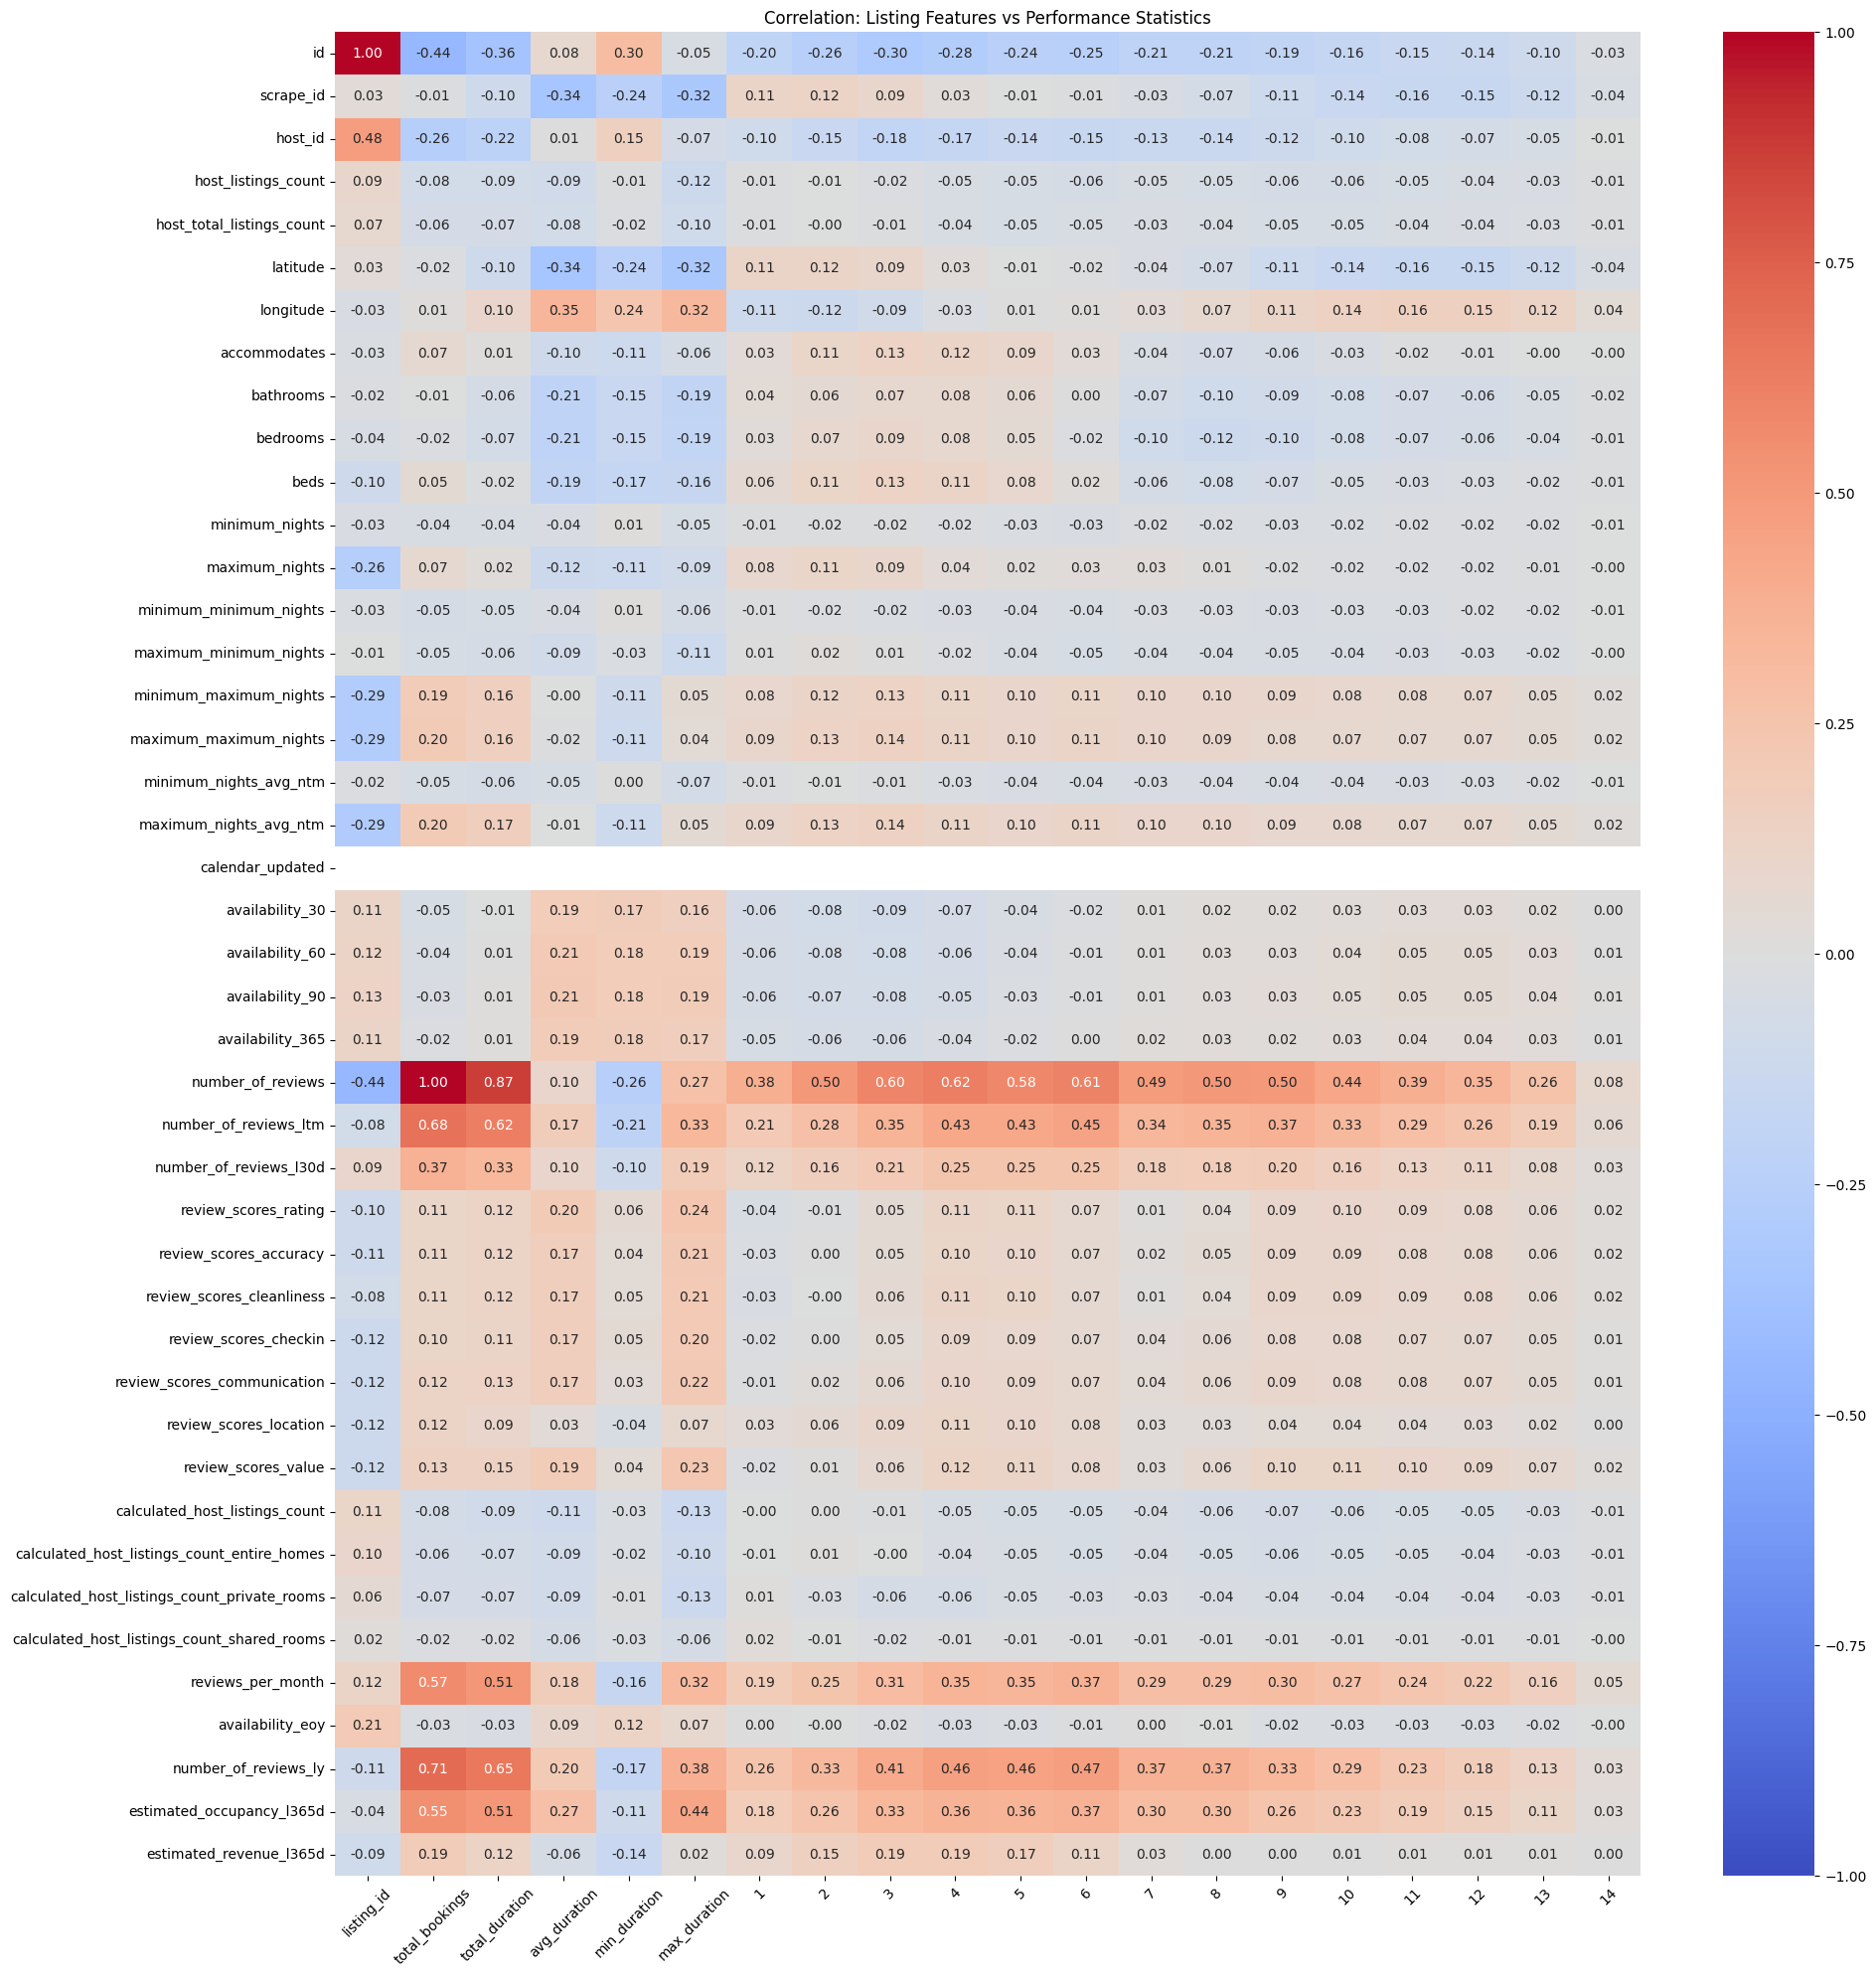

In [106]:
corr_matrix = merged_df.corr()

feature_to_stat_corr = corr_matrix.loc[numerical_columns, statistical_columns]

plt.figure(figsize=(20, 20))
sns.heatmap(feature_to_stat_corr,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Correlation: Listing Features vs Performance Statistics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Mutual Information

In [ ]:
statistical_columns

Index([    'listing_id', 'total_bookings', 'total_duration',   'avg_duration',
         'min_duration',   'max_duration',                1,                2,
                      3,                4,                5,                6,
                      7,                8,                9,               10,
                     11,               12,               13,               14],
      dtype='object')

In [ ]:
mi_df = pd.merge(
    listings_statistics,
    booked_listings[numerical_columns],
    left_on='listing_id',
    right_on='id',
    how='right'
)

# drop columns which contains NaN values
mi_df.drop(columns=mi_df.columns[mi_df.isnull().any()].tolist(), inplace=True)


,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,1,2,3,4,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_communication,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,27262.0,29,144,4.965517,2,7,0,1,2,6,...,5,0,4.86,4.89,4.97,1,1,0,0,0.19
1,809874.0,97,288,2.969072,1,5,6,23,39,26,...,6,0,4.96,4.97,4.92,1,1,0,0,0.68
2,866381.0,40,383,9.575000,3,12,0,0,1,0,...,31,1,4.95,4.98,4.93,1,1,0,0,0.28
3,886724.0,18,115,6.388889,3,9,0,0,2,0,...,0,0,4.61,4.88,4.89,1,1,0,0,0.14
4,896212.0,515,4979,9.667961,2,13,0,2,4,6,...,49,2,4.95,4.94,4.93,13,13,0,0,3.58


In [131]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import matplotlib.pyplot as plt

def compute_and_plot_mi(df, target_column, discrete_target=True, top_k=None):

    X = df.drop(columns=[target_column])
    y = df[target_column]

    numeric_cols = X.select_dtypes(include=['int', 'float']).columns
    X = X[numeric_cols]

    # Compute MI
    if discrete_target:
        mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)
    else:
        mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)

    mi_series = pd.Series(mi, index=X.columns)
    mi_series = mi_series.sort_values(ascending=False)

    if top_k:
        mi_series = mi_series.head(top_k)

    # Plot
    plt.figure(figsize=(20, 6))
    mi_series.plot(kind='bar')
    plt.title(f"Mutual Information with target = '{target_column}'")
    plt.ylabel("Mutual Information Score")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return mi_series


Computing MI for target: 10


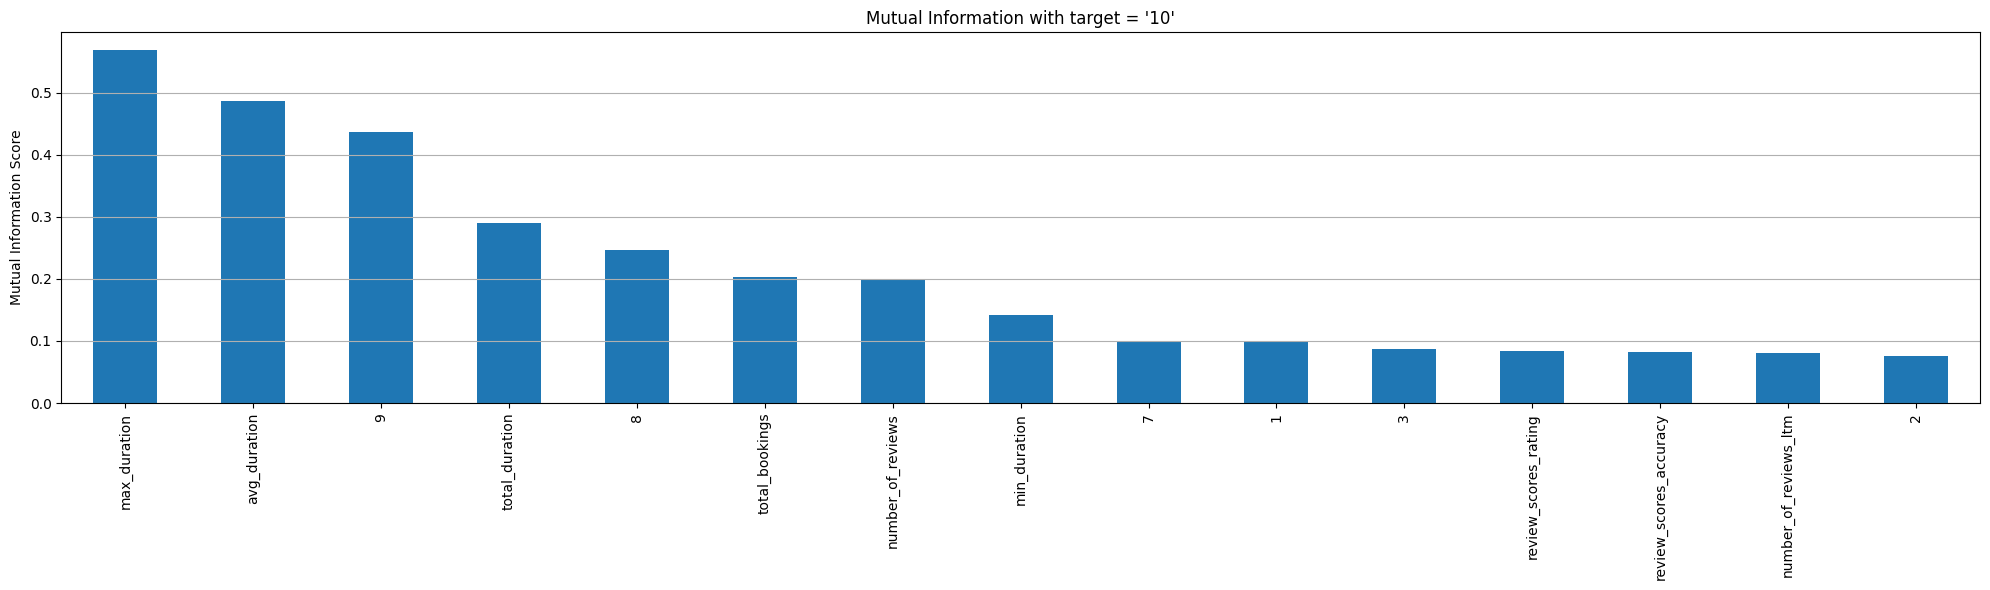

Computing MI for target: 11


KeyboardInterrupt: 

In [ ]:
original_stat_cols = [col for col in statistical_columns if col != 'listing_id']

for stat_col in original_stat_cols:
    df = mi_df.copy()
    df.drop(columns=[stat_col], inplace=True)
    df[stat_col] = mi_df[stat_col]
    print(f"Computing MI for target: {stat_col}")
    compute_and_plot_mi(df, stat_col, discrete_target=False, top_k=15)